In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [253]:
train_dir = "../dataset/train"
test_dir = "../dataset/test"

In [260]:
# Configuration
MODE = "dev"  # "debug" | "dev" | "final"

PARAMS = {
    "debug": {"epochs": 3, "batch_size": 32, "img_size": 48, "color_mode": "grayscale", "data_percent": 0.1},
    "dev": {"epochs": 70, "batch_size": 128, "img_size": 48, "color_mode": "grayscale", "data_percent": 1.0},
    "final": {"epochs": 40, "batch_size": 64, "img_size": 48, "color_mode": "grayscale", "data_percent": 1.0}
}

CFG = PARAMS[MODE]
EPOCHS, BATCH_SIZE, IMG_SIZE, COLOR_MODE, DATA_PERCENT = CFG.values()
SAVE_NAME = f'model_{MODE}.keras'

print(f"MODE: {MODE} | Epochs: {EPOCHS} | Batch: {BATCH_SIZE} | Data: {DATA_PERCENT*100:.0f}%")


MODE: dev | Epochs: 70 | Batch: 128 | Data: 100%


Génération de modèle


In [ ]:


# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE, class_mode="categorical", shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE, class_mode="categorical", shuffle= False 
)

# Limiter le pourcentage d’images
if DATA_PERCENT < 1.0:
    for gen in [train_generator]:
        gen.samples = gen.n = math.ceil(gen.samples * DATA_PERCENT)
        gen._set_index_array()
    print(f"Mode {MODE}: {DATA_PERCENT*100:.0f}% des données utilisées")


Found 28709 images belonging to 7 classes.
Found 4254 images belonging to 7 classes.


In [262]:
# Labels des émotions
LABELS = sorted(train_generator.class_indices.keys())
label_dict = {i: label for i, label in enumerate(LABELS)}
print(f"Classes: {LABELS}")


Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [263]:
# Construction du modèle
channels = 1 if COLOR_MODE == "grayscale" else 3
input_shape = (IMG_SIZE, IMG_SIZE, channels)
num_classes = train_generator.num_classes

def build_model(mode, input_shape, num_classes):
    model = Sequential()
    
    if mode == "debug":
        model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPool2D(2))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        
    elif mode == "dev":
        model= tf.keras.models.Sequential()

# Bloc 1: 32 filtres
        model.add(Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=(48, 48, 1), name='conv1'))
        model.add(BatchNormalization(name='bn1'))
        model.add(Activation('relu', name='relu1'))
        model.add(MaxPool2D(pool_size=(2, 2), name='pool1'))

        # Bloc 2: 64 filtres
        model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, name='conv2'))
        model.add(BatchNormalization(name='bn2'))
        model.add(Activation('relu', name='relu2'))
        model.add(MaxPool2D(pool_size=(2, 2), name='pool2'))
        model.add(Dropout(0, name='drop2'))

        # Bloc 3: 128 filtres (noyau 5x5 comme dans ton code)
        model.add(Conv2D(128, (5, 5), padding='same', use_bias=False, name='conv3'))
        model.add(BatchNormalization(name='bn3'))
        model.add(Activation('relu', name='relu3'))
        model.add(MaxPool2D(pool_size=(2, 2), name='pool3'))
        model.add(Dropout(0.1, name='drop3'))

        # Bloc 4: 512 filtres (avec L2 comme dans ton code)
        model.add(Conv2D(512, (3, 3), padding='same', use_bias=False,kernel_regularizer=regularizers.l2(0.0005), name='conv4'))
        model.add(BatchNormalization(name='bn4'))
        model.add(Activation('relu', name='relu4'))
        model.add(MaxPool2D(pool_size=(2, 2), name='pool4'))
        model.add(Dropout(0.2, name='drop4'))

        model.add(GlobalAveragePooling2D(name='gap'))
        model.add(Dense(256, use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.3))



        
    else:  # final
        # Modèle 3 convolution
        # Bloc 1
        model.add(Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(48,48,1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D((2,2)))
        model.add(Dropout(0))

        # Bloc 2
        model.add(Conv2D(64, (3,3), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D((2,2)))
        model.add(Dropout(0.25))

        # Bloc 3
        model.add(Conv2D(256, (3,3), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D((2,2)))
        model.add(Dropout(0.25))

        # Tête
        model.add(GlobalAveragePooling2D())
        model.add(Dense(256, use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.3))

    
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(MODE, input_shape, num_classes)
model.summary()


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 24, 24, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 12, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 6, 6, 512)      │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 6, 6, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 950,183 (3.62 MB)

 Trainable params: 948,199 (3.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Entraînement
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

model.save(SAVE_NAME)
print(f" Modèle sauvegardé: {SAVE_NAME}")


Epoch 1/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 105s 450ms/step - accuracy: 0.2333 - loss: 2.1329 - val_accuracy: 0.1831 - val_loss: 1.9553
Epoch 2/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 428ms/step - accuracy: 0.3028 - loss: 1.9148 - val_accuracy: 0.2576 - val_loss: 1.9220
Epoch 3/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 112s 499ms/step - accuracy: 0.3416 - loss: 1.8191 - val_accuracy: 0.3881 - val_loss: 1.6795
Epoch 4/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 109s 486ms/step - accuracy: 0.3639 - loss: 1.7675 - val_accuracy: 0.3888 - val_loss: 1.6526
Epoch 5/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 108s 480ms/step - accuracy: 0.3887 - loss: 1.7032 - val_accuracy: 0.4459 - val_loss: 1.5427
Epoch 6/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 115s 510ms/step - accuracy: 0.4032 - loss: 1.6603 - val_accuracy: 0.4076 - val_loss: 1.6297
Epoch 7/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 126s 560ms/step - accuracy: 0.4213 - loss: 1.6178 - val_accuracy: 0.4429 - val_loss: 1.5444
Epoch 8/70
225/225 ━━━━━━━━━━━━━━━━━━━━ 119s 527ms/step - accuracy: 0.4384 - 

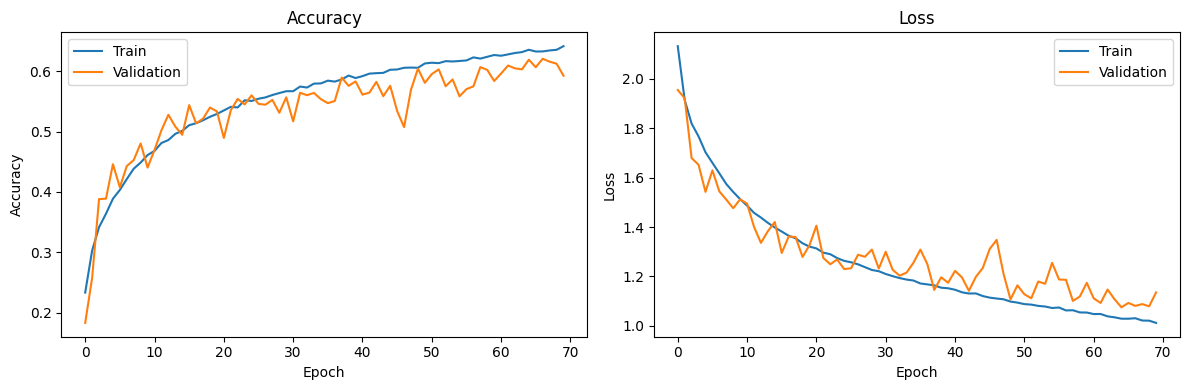

In [265]:
# Visualisation de l'entraînement
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [266]:
# Évaluation
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
print(f"Train accuracy: {train_acc*100:.2f}% | Validation accuracy: {val_acc*100:.2f}%")


Train accuracy: 60.69% | Validation accuracy: 58.13%


In [267]:
# Fonction de prédiction
def predict_emotion(img_path):
    """Prédit l'émotion d'une image"""
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode=COLOR_MODE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array, verbose=0)[0]
    class_idx = int(np.argmax(preds))
    confidence = float(preds[class_idx])
    emotion = label_dict[class_idx]
    
    plt.imshow(img, cmap="gray" if COLOR_MODE == "grayscale" else None)
    plt.axis("off")
    plt.title(f"{emotion} ({confidence*100:.2f}%)")
    plt.show()
    
    print(f"Émotion: {emotion} | Confiance: {confidence*100:.2f}%")
    return emotion, confidence

# Exemple d'utilisation
# predict_emotion("../dataset/test/happy/im1021.png")


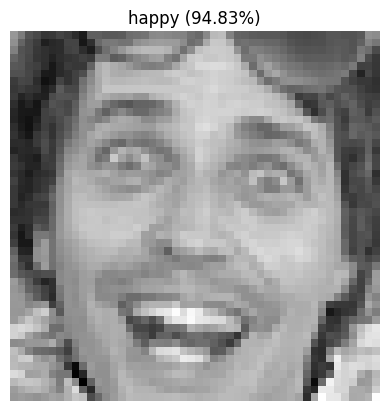

Émotion: happy | Confiance: 94.83%


('happy', 0.94829261302948)

In [268]:
# Test de prédiction sur une image
img_path = "../dataset/test/happy/im1021.png"
predict_emotion(img_path)

In [269]:
# Charger un modèle sauvegardé (si nécessaire)
if not 'model' in locals():
    if Path(SAVE_NAME).exists():
        model = load_model(SAVE_NAME)
        print(f"✅ Modèle chargé: {SAVE_NAME}")
    else:
        print(f"⚠️ Modèle non trouvé: {SAVE_NAME}")
